<a href="https://colab.research.google.com/github/betyavan/ML-practice/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [7]:
! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets download spandan2/cats-faces-64x64-for-generative-models

 84% 81.0M/96.0M [00:04<00:00, 19.3MB/s]
100% 96.0M/96.0M [00:04<00:00, 24.4MB/s]


In [10]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image, make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [11]:
! unzip -q cats-faces-64x64-for-generative-models.zip

In [12]:
DATA_DIR = './cats/'

In [13]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [15]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)
]))

In [16]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [17]:
next(iter(train_dl))

[tensor([[[[-0.2157, -0.2000,  0.0196,  ...,  0.0667, -0.1608,  0.0431],
           [-0.3176, -0.3412, -0.0745,  ..., -0.0588, -0.0588, -0.0275],
           [-0.2863, -0.2941, -0.1608,  ..., -0.0902, -0.0902, -0.3569],
           ...,
           [ 0.7961,  0.7804,  0.7804,  ..., -0.5373, -0.4824, -0.6471],
           [ 0.7725,  0.8353,  0.7569,  ..., -0.7333, -0.2000, -0.5765],
           [ 0.8275,  0.7804,  0.8588,  ..., -0.5686, -0.8431, -0.5686]],
 
          [[-0.3176, -0.3098, -0.0902,  ..., -0.0510, -0.2863, -0.0667],
           [-0.4275, -0.4510, -0.1922,  ..., -0.1686, -0.1765, -0.1529],
           [-0.4118, -0.4196, -0.2706,  ..., -0.2000, -0.1922, -0.4667],
           ...,
           [ 0.6549,  0.6314,  0.6314,  ..., -0.6392, -0.5843, -0.7647],
           [ 0.6314,  0.6941,  0.6157,  ..., -0.7961, -0.2706, -0.6706],
           [ 0.7020,  0.6549,  0.7333,  ..., -0.6157, -0.8980, -0.6235]],
 
          [[-0.5686, -0.5373, -0.3176,  ..., -0.5137, -0.6863, -0.4196],
           [-

In [18]:
def denorm(img_tensors):
  return img_tensors * stats[1][0] + stats[0][0]

In [21]:
def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1,2,0))

def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

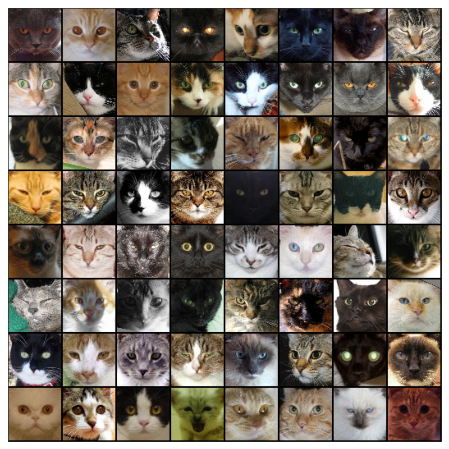

In [22]:
show_batch(train_dl)

In [23]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

In [24]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
  
  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [26]:
train_dl = DeviceDataLoader(train_dl, device)

In [27]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [28]:
discriminator = to_device(discriminator, device)

In [29]:
latent_size = 128

In [30]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

как выглядит шум, из которого будут генерироваться изображения

torch.Size([128, 3, 64, 64])


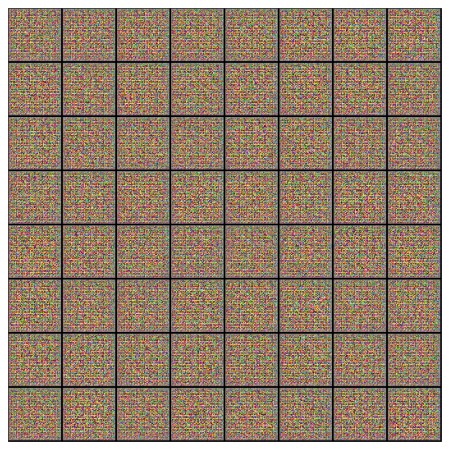

In [31]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [32]:
generator = to_device(generator, device)

In [33]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [34]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [36]:
def save_samples(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
  print('Saving', fake_fname)
  if show:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1,2,0))

gan's training

сначала учим дискриминатор, после генератор

In [37]:
def fit(model, criterion, epochs, lr, start_idx=1):
  model['discriminator'].train()
  model['generator'].train()
  torch.cuda.empty_cache()

  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  optimizer = {
      "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                        lr=lr, betas=(0.5, 0.999)),
      "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
  }

  for epoch in tqdm(range(epochs)):
    loss_d_per_epoch = []
    loss_g_per_epoch = []
    real_score_per_epoch = []
    fake_score_per_epoch = []

    for real_images, _ in tqdm(train_dl):
      # TRAIN DISCRIMINATOR
      optimizer['discriminator'].zero_grad()

      real_preds = model["discriminator"](real_images)
      real_targets = torch.ones(real_images.size(0), 1, device=device)
      real_loss = criterion['discriminator'](real_preds, real_targets)
      cur_real_score = torch.mean(real_preds).item()

      # generate fake images
      latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
      fake_images = model["generator"](latent)

      # pass fake images through discriminator
      fake_targets = torch.zeros(fake_images.size(0), 1, device = device)
      fake_preds = model['discriminator'](fake_images)
      fake_loss = criterion['discriminator'](fake_preds, fake_targets)
      cur_fake_score = torch.mean(fake_preds).item()

      real_score_per_epoch.append(cur_real_score)
      fake_score_per_epoch.append(cur_fake_score)

      # update discriminator weights
      loss_d = real_loss + fake_loss
      loss_d.backward()
      optimizer['discriminator'].step()
      loss_d_per_epoch.append(loss_d.item())

      # TRAIN GENERATOR
      optimizer['generator'].zero_grad()

      # generate fake images
      latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
      fake_images = model['generator'](latent)

      # try to fool the discriminator
      preds = model['discriminator'](fake_images)
      targets = torch.ones(batch_size, 1, device=device)
      loss_g = criterion["generator"](preds, targets)

      # update generator weights
      loss_g.backward()
      optimizer["generator"].step()
      loss_g_per_epoch.append(loss_g.item())

    losses_g.append(np.mean(loss_g_per_epoch))
    losses_d.append(np.mean(loss_d_per_epoch))
    real_scores.append(np.mean(real_score_per_epoch))
    fake_scores.append(np.mean(fake_score_per_epoch))


    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
    if epoch == epochs - 1:
      save_samples(epoch+start_idx, fixed_latent, show=False)

  return losses_g, losses_d, real_scores, fake_scores

In [38]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
lr = 0.0002
epochs = 40

In [39]:
history = fit(model, criterion, epochs, lr)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [1/40], loss_g: 7.1317, loss_d: 0.5630, real_score: 0.8152, fake_score: 0.1862


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [2/40], loss_g: 5.4588, loss_d: 0.3406, real_score: 0.8743, fake_score: 0.1189


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [3/40], loss_g: 4.6376, loss_d: 0.6489, real_score: 0.7989, fake_score: 0.2002


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [4/40], loss_g: 4.3518, loss_d: 0.5649, real_score: 0.8051, fake_score: 0.1941


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [5/40], loss_g: 4.4878, loss_d: 0.6424, real_score: 0.7875, fake_score: 0.2078


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [6/40], loss_g: 4.3358, loss_d: 0.7261, real_score: 0.7657, fake_score: 0.2370


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [7/40], loss_g: 4.7338, loss_d: 0.7048, real_score: 0.7794, fake_score: 0.2193


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [8/40], loss_g: 4.6083, loss_d: 0.6978, real_score: 0.7793, fake_score: 0.2180


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [9/40], loss_g: 4.7753, loss_d: 0.6729, real_score: 0.7840, fake_score: 0.2157


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [10/40], loss_g: 4.6504, loss_d: 0.7318, real_score: 0.7811, fake_score: 0.2175


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [11/40], loss_g: 4.4876, loss_d: 0.6629, real_score: 0.7814, fake_score: 0.2136


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [12/40], loss_g: 4.2780, loss_d: 0.6994, real_score: 0.7782, fake_score: 0.2227


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [13/40], loss_g: 4.5381, loss_d: 0.5957, real_score: 0.7980, fake_score: 0.1995


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [14/40], loss_g: 4.3710, loss_d: 0.6997, real_score: 0.7759, fake_score: 0.2254


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [15/40], loss_g: 4.4199, loss_d: 0.6065, real_score: 0.7996, fake_score: 0.1970


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [16/40], loss_g: 4.5282, loss_d: 0.6320, real_score: 0.8106, fake_score: 0.1941


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [17/40], loss_g: 4.5786, loss_d: 0.5837, real_score: 0.8188, fake_score: 0.1787


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [18/40], loss_g: 4.6407, loss_d: 0.4998, real_score: 0.8373, fake_score: 0.1611


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [19/40], loss_g: 4.4974, loss_d: 0.5671, real_score: 0.8287, fake_score: 0.1723


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [20/40], loss_g: 4.7452, loss_d: 0.5203, real_score: 0.8315, fake_score: 0.1600


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [21/40], loss_g: 4.5529, loss_d: 0.4734, real_score: 0.8455, fake_score: 0.1573


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [22/40], loss_g: 4.7676, loss_d: 0.5584, real_score: 0.8319, fake_score: 0.1695


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [23/40], loss_g: 5.0409, loss_d: 0.4414, real_score: 0.8633, fake_score: 0.1344


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [24/40], loss_g: 4.8030, loss_d: 0.4285, real_score: 0.8639, fake_score: 0.1365


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [25/40], loss_g: 5.4839, loss_d: 0.3789, real_score: 0.8782, fake_score: 0.1184


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [26/40], loss_g: 5.0973, loss_d: 0.4005, real_score: 0.8712, fake_score: 0.1295


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [27/40], loss_g: 5.3343, loss_d: 0.4138, real_score: 0.8763, fake_score: 0.1218


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [28/40], loss_g: 5.5244, loss_d: 0.2674, real_score: 0.9116, fake_score: 0.0900


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [29/40], loss_g: 5.4999, loss_d: 0.3656, real_score: 0.8956, fake_score: 0.1060


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [30/40], loss_g: 5.7643, loss_d: 0.2603, real_score: 0.9118, fake_score: 0.0882


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [31/40], loss_g: 5.6964, loss_d: 0.3238, real_score: 0.8955, fake_score: 0.0999


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [32/40], loss_g: 5.7286, loss_d: 0.3434, real_score: 0.8965, fake_score: 0.1060


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [33/40], loss_g: 6.2304, loss_d: 0.2993, real_score: 0.9049, fake_score: 0.0918


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [34/40], loss_g: 6.2484, loss_d: 0.3071, real_score: 0.9106, fake_score: 0.0928


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [35/40], loss_g: 6.4118, loss_d: 0.2780, real_score: 0.9220, fake_score: 0.0732


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [36/40], loss_g: 5.5411, loss_d: 0.3833, real_score: 0.8955, fake_score: 0.1109


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [37/40], loss_g: 6.2208, loss_d: 0.2924, real_score: 0.9110, fake_score: 0.0848


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [38/40], loss_g: 5.9419, loss_d: 0.2401, real_score: 0.9220, fake_score: 0.0796


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [39/40], loss_g: 6.8797, loss_d: 0.2220, real_score: 0.9293, fake_score: 0.0680


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [40/40], loss_g: 6.0392, loss_d: 0.3395, real_score: 0.9101, fake_score: 0.0917
Saving generated-images-0040.png


In [40]:
losses_g, losses_d, real_scores, fake_scores = history

In [41]:
generated_img = cv2.imread(f'./generated/generated-images-00{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]

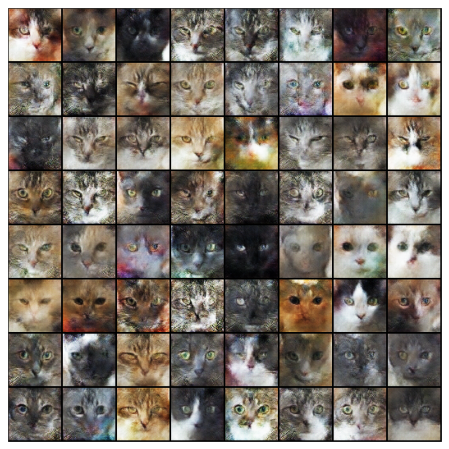

In [42]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

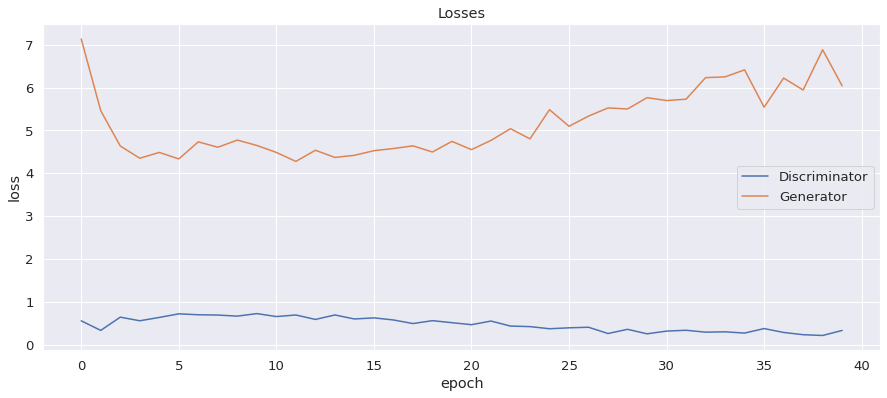

In [43]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

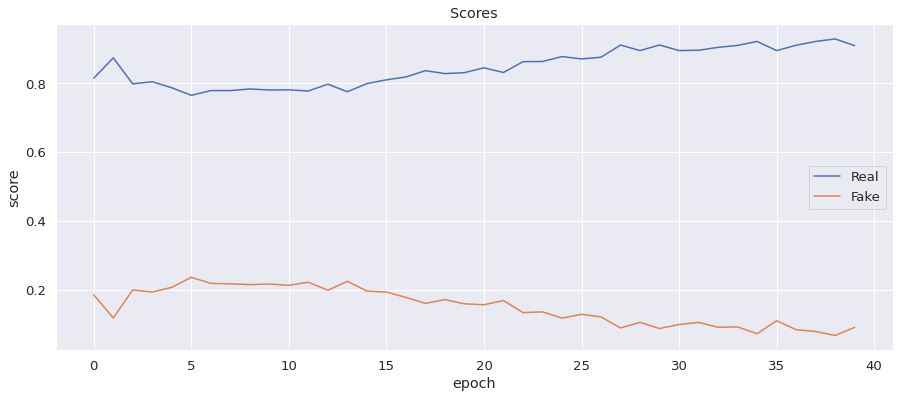

In [44]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');